In [52]:
# Шаг 1: Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

plt.style.use('ggplot')
print("Шаг 1: Библиотеки импортированы.\n")

Шаг 1: Библиотеки импортированы.



In [53]:
# Шаг 2: Загрузка данных
try:
    train_df = pd.read_csv('fmnist_train.csv')
    test_df = pd.read_csv('fmnist_test.csv')
    print("Шаг 2: Данные успешно загружены.")
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден: {e.filename}. Убедитесь, что файлы загружены.")
    exit()
except Exception as e:
    print(f"Произошла ошибка при загрузке данных: {e}")
    exit()
print("\n")

Шаг 2: Данные успешно загружены.




In [55]:
# Шаг 3: Первичный анализ и очистка данных
print("Шаг 3: Первичный анализ и очистка данных.\n")

# Обработка NaN в обучающем датасете (train_df)
print(f"Обработка NaN в обучающем датасете (train_df):")
print(f"  Начальное количество NaN: {train_df.isnull().sum().sum()}")
if train_df.isnull().values.any():
    initial_rows_train = len(train_df)
    train_df.dropna(inplace=True)
    print(f"  Удалено {initial_rows_train - len(train_df)} строк с NaN.")
    print(f"  Количество NaN после удаления: {train_df.isnull().sum().sum()}")
else:
    print("  NaN в обучающем датасете не найдены.")

# Обработка NaN в тестовом датасете (test_df)
print(f"\nОбработка NaN в тестовом датасете (test_df):")
if not test_df.empty:
    test_id_column_name = test_df.columns[-1] # Предполагаем, что последний столбец - это ID
    test_pixel_columns = [col for col in test_df.columns if col != test_id_column_name]

    print(f"  Столбец ID в test_df: '{test_id_column_name}'")
    print(f"  Пиксельные столбцы в test_df: {len(test_pixel_columns)} шт.")

    # Заполняем NaN в пиксельных столбцах нулями
    nans_in_test_pixels_before = test_df[test_pixel_columns].isnull().sum().sum()
    if nans_in_test_pixels_before > 0:
        test_df[test_pixel_columns] = test_df[test_pixel_columns].fillna(0)
        print(f"  {nans_in_test_pixels_before} NaN в пиксельных столбцах тестового датасета были заменены на 0.")
    else:
        print("  NaN в пиксельных столбцах тестового датасета не найдены.")

    # Проверяем столбец ID на NaN (мы его не заполняли нулями!)
    nans_in_test_id_col = test_df[test_id_column_name].isnull().sum()
    if nans_in_test_id_col > 0:
        print(f"  ПРЕДУПРЕЖДЕНИЕ: В столбце ID ('{test_id_column_name}') тестового датасета найдено {nans_in_test_id_col} NaN.")
        print(f"  Это КРИТИЧЕСКАЯ ПРОБЛЕМА для submission. Проверьте исходный файл 'fmnist_test.csv'.")
        print(f"  Строки с NaN в ID: \n{test_df[test_df[test_id_column_name].isnull()].head()}")
        # Если ID не должны содержать NaN, это нужно исправить в fmnist_test.csv или решить, как их обрабатывать
        # Например, удалить строки с NaN ID: test_df.dropna(subset=[test_id_column_name], inplace=True)
        # Но это изменит количество тестовых примеров.
    else:
        print(f"  NaN в столбце ID ('{test_id_column_name}') тестового датасета не найдены.")
    print(f"  Общее количество NaN в тестовом датасете после выборочного заполнения: {test_df.isnull().sum().sum()}")
else:
    print("Тестовый датасет пуст.")


print(f"\nРазмерность обучающего датасета после очистки: {train_df.shape}")
print(f"Размерность тестового датасета после очистки: {test_df.shape}")
print("\n")

Шаг 3: Первичный анализ и очистка данных.

Обработка NaN в обучающем датасете (train_df):
  Начальное количество NaN: 0
  NaN в обучающем датасете не найдены.

Обработка NaN в тестовом датасете (test_df):
  Столбец ID в test_df: 'Id'
  Пиксельные столбцы в test_df: 784 шт.
  NaN в пиксельных столбцах тестового датасета не найдены.
  NaN в столбце ID ('Id') тестового датасета не найдены.
  Общее количество NaN в тестовом датасете после выборочного заполнения: 0

Размерность обучающего датасета после очистки: (17039, 786)
Размерность тестового датасета после очистки: (10000, 785)




In [56]:
# Шаг 4: Подготовка данных для модели
print("Шаг 4: Подготовка данных для модели.\n")

class_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
               5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
num_classes = 10
IMG_HEIGHT, IMG_WIDTH = 28, 28
EXPECTED_PIXELS = IMG_HEIGHT * IMG_WIDTH

if train_df.empty:
    print("ОШИБКА: Обучающий датасет пуст. Дальнейшая обработка невозможна."); exit()

# Подготовка обучающих данных
y_train_full = train_df.iloc[:, 0]
X_train_full_pixels = train_df.iloc[:, 1:(1 + EXPECTED_PIXELS)]

# Подготовка тестовых данных
if test_df.empty:
    print("ОШИБКА: Тестовый датасет пуст. Дальнейшая обработка невозможна."); exit()

# Извлечение ID из тестового набора
test_ids_series = test_df.iloc[:, -1].copy() # Последний столбец
print(f"Анализ извлеченных ID для тестовой выборки (из столбца '{test_df.columns[-1]}'):")
print(f"  Исходный тип данных ID: {test_ids_series.dtype}")
print(f"  Количество ID: {len(test_ids_series)}, Количество уникальных ID: {test_ids_series.nunique()}")

if test_ids_series.isnull().any():
    print(f"  КРИТИЧЕСКОЕ ПРЕДУПРЕЖДЕНИЕ: Найдены NaN значения в ID ({test_ids_series.isnull().sum()} шт.)!")
    print(f"  Это необходимо исправить в 'fmnist_test.csv' или решить, как обрабатывать эти ID (например, удалить или заполнить уникальными плейсхолдерами).")

# Попытка преобразовать ID в целые числа (Kaggle обычно ожидает int ID)
try:
    test_ids = test_ids_series.astype(np.int64) # Используем np.int64 для совместимости
    print(f"  Тип данных ID после преобразования в int: {test_ids.dtype}")
except ValueError as e:
    print(f"  ОШИБКА при преобразовании ID в int: {e}. Это часто происходит из-за NaN или нечисловых значений.")
    print(f"  Проверьте столбец ID ('{test_df.columns[-1]}') в 'fmnist_test.csv'. Используем исходные ID, что может привести к ошибке на Kaggle.")
    test_ids = test_ids_series # Возвращаемся к исходной серии в случае ошибки

# Проверка на дубликаты в test_ids ПОСЛЕ преобразования в int
if isinstance(test_ids, pd.Series):
    num_duplicates_in_ids = test_ids.duplicated().sum()
    if num_duplicates_in_ids > 0:
        print(f"  КРИТИЧЕСКАЯ ОШИБКА: В test_ids найдено {num_duplicates_in_ids} дублирующихся значений!")
        duplicated_id_values = test_ids[test_ids.duplicated(keep=False)]
        print(f"    Примеры дублирующихся ID (первые 5 уникальных дубликатов и их частота):\n{duplicated_id_values.value_counts().head()}")
        if 0 in duplicated_id_values.unique(): # Проверяем наличие 0 среди дубликатов
             print(f"    ПРЕДУПРЕЖДЕНИЕ: Среди дубликатов присутствует ID '0' (или '0.0' до преобразования в int).")
        print(f"    Это приведет к ошибке на Kaggle. Необходимо обеспечить уникальность ID в 'fmnist_test.csv'.")
    else:
        print("  Дубликаты в обработанных test_ids не найдены. ID уникальны.")
else:
    print("  Переменная test_ids не была корректно создана/обработана.")


X_test_pixels = test_df.iloc[:, 0:EXPECTED_PIXELS]

# Проверки размеров и нормализация
if X_train_full_pixels.shape[1] != EXPECTED_PIXELS: print(f"Ошибка: X_train_full_pixels столбцов {X_train_full_pixels.shape[1]}, ожидалось {EXPECTED_PIXELS}."); exit()
if X_test_pixels.shape[1] != EXPECTED_PIXELS: print(f"Ошибка: X_test_pixels столбцов {X_test_pixels.shape[1]}, ожидалось {EXPECTED_PIXELS}."); exit()

X_train_normalized = X_train_full_pixels / 255.0
X_test_normalized = X_test_pixels / 255.0
X_train_reshaped = X_train_normalized.values.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
X_test_reshaped = X_test_normalized.values.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

if y_train_full.min() < 0 or y_train_full.max() >= num_classes: print(f"ОШИБКА: Метки y_train_full вне диапазона [0, {num_classes-1}]!"); exit()
y_train_full_cat = to_categorical(y_train_full, num_classes=num_classes)

if X_train_reshaped.shape[0] != y_train_full_cat.shape[0]: print("ОШИБКА: Несоответствие строк X_train_reshaped и y_train_full_cat."); exit()

X_train, X_val, y_train_cat, y_val_cat = train_test_split(
    X_train_reshaped, y_train_full_cat, test_size=0.2, random_state=42, stratify=y_train_full)

print(f"\nРазмерности после разделения: X_train: {X_train.shape}, X_val: {X_val.shape}\n")

Шаг 4: Подготовка данных для модели.

Анализ извлеченных ID для тестовой выборки (из столбца 'Id'):
  Исходный тип данных ID: int64
  Количество ID: 10000, Количество уникальных ID: 10000
  Тип данных ID после преобразования в int: int64
  Дубликаты в обработанных test_ids не найдены. ID уникальны.

Размерности после разделения: X_train: (13631, 28, 28, 1), X_val: (3408, 28, 28, 1)



In [57]:
# Шаг 4.1: Проверка данных перед model.fit() (без изменений, код как в предыдущей версии)
print("Шаг 4.1: Проверка данных непосредственно перед model.fit()\n")
datasets_to_check = {"X_train": X_train, "y_train_cat": y_train_cat, "X_val": X_val, "y_val_cat": y_val_cat}
all_data_ok = True
for name, data in datasets_to_check.items():
    print(f"Проверка {name}:")
    if data.size == 0: print(f"  ОШИБКА: Массив {name} пуст!"); all_data_ok = False; continue
    if np.isnan(data).any(): print(f"  ОШИБКА: NaN в {name}!"); all_data_ok = False
    else: print(f"  NaN в {name}: Нет")
    if np.isinf(data).any(): print(f"  ОШИБКА: Inf в {name}!"); all_data_ok = False
    else: print(f"  Inf в {name}: Нет")
    if "X_" in name:
        print(f"  Мин: {data.min():.4f}, Макс: {data.max():.4f}")
        if data.min() < 0.0 or data.max() > 1.0: print(f"  ПРЕДУПРЕЖДЕНИЕ: Значения в {name} вне [0, 1]!")
    elif "y_" in name:
        if not np.allclose(np.sum(data, axis=1), 1.0): print(f"  ОШИБКА: Строки в {name} (one-hot) не суммируются в 1!"); all_data_ok = False
        else: print(f"  Строки в {name} (one-hot) корректны.")
if not all_data_ok: print("\nОШИБКА В ДАННЫХ ДЛЯ МОДЕЛИ! Устраните проблемы."); exit()
else: print("\nДанные для модели выглядят готовыми.\n")

Шаг 4.1: Проверка данных непосредственно перед model.fit()

Проверка X_train:
  NaN в X_train: Нет
  Inf в X_train: Нет
  Мин: 0.0000, Макс: 1.0000
Проверка y_train_cat:
  NaN в y_train_cat: Нет
  Inf в y_train_cat: Нет
  Строки в y_train_cat (one-hot) корректны.
Проверка X_val:
  NaN в X_val: Нет
  Inf в X_val: Нет
  Мин: 0.0000, Макс: 1.0000
Проверка y_val_cat:
  NaN в y_val_cat: Нет
  Inf в y_val_cat: Нет
  Строки в y_val_cat (one-hot) корректны.

Данные для модели выглядят готовыми.



In [58]:
# Шаг 5: Построение модели CNN (без изменений)
print("Шаг 5: Построение модели CNN.\n")
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), padding='same'), MaxPooling2D((2,2)), Dropout(0.25),
    Conv2D(64, (3,3), activation='relu', padding='same'), MaxPooling2D((2,2)), Dropout(0.25),
    Conv2D(128, (3,3), activation='relu', padding='same'), MaxPooling2D((2,2)), Dropout(0.3),
    Flatten(), Dense(128, activation='relu'), Dropout(0.5), Dense(num_classes, activation='softmax')])
model.summary(); print("\n")

Шаг 5: Построение модели CNN.



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# Шаг 6: Компиляция модели (без изменений)
print("Шаг 6: Компиляция модели.\n")
optimizer = SGD(learning_rate=0.001, momentum=0.9, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
print("Модель скомпилирована с SGD.\n")

Шаг 6: Компиляция модели.

Модель скомпилирована с SGD.



In [61]:
# Шаг 7: Обучение модели (с проверкой на пустые данные)
print("Шаг 7: Обучение модели.\n")
history, val_loss, val_accuracy = None, np.nan, np.nan
if X_train.size == 0 or y_train_cat.size == 0:
    print("ОШИБКА: Обучающие данные пусты. Обучение невозможно.")
else:
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    history = model.fit(X_train, y_train_cat, epochs=300, batch_size=64, validation_data=(X_val, y_val_cat), verbose=1)
print("Обучение модели завершено (или пропущено).\n")

Шаг 7: Обучение модели.

Epoch 1/300
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1430 - loss: 2.2618 - val_accuracy: 0.4657 - val_loss: 1.9335
Epoch 2/300
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3367 - loss: 1.8372 - val_accuracy: 0.5634 - val_loss: 1.3934
Epoch 3/300
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4201 - loss: 1.5027 - val_accuracy: 0.6065 - val_loss: 1.1828
Epoch 4/300
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4961 - loss: 1.3011 - val_accuracy: 0.5971 - val_loss: 1.0858
Epoch 5/300
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5199 - loss: 1.2055 - val_accuracy: 0.6414 - val_loss: 1.0055
Epoch 6/300
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5562 - loss: 1.1216 - val_accuracy: 0.6523 - val_loss: 0.9468
Epoch 7/300
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5760 - loss: 1.0875 - val_accuracy: 0.6546 - val_loss: 0.9106
Epoch 8/300
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5908

In [63]:
# Шаг 8: Оценка модели (с проверкой)
print("Шаг 8: Оценка модели.\n")
if history and hasattr(history, 'model') and history.model:
    val_loss, val_accuracy = model.evaluate(X_val, y_val_cat, verbose=0)
    print(f"Точность на валидации: {val_accuracy:.4f}")
else:
    print(f"Оценка пропущена. val_loss: {val_loss}, val_accuracy: {val_accuracy}")
print("\n")

Шаг 8: Оценка модели.

Точность на валидации: 0.8903




In [64]:
# Шаг 9: Предсказание на тестовых данных
print("Шаг 9: Предсказание на тестовых данных.\n")
predicted_labels = []
if model and history and not np.isnan(val_loss): # Убедимся, что модель обучилась
    if X_test_reshaped.size > 0:
        predictions_proba = model.predict(X_test_reshaped)
        predicted_labels = np.argmax(predictions_proba, axis=1)
        print(f"Первые 10 предсказанных меток: {predicted_labels[:10]}")
    else: print("Тестовые данные (X_test_reshaped) пусты.")
else: print("Модель не обучена или обучена с ошибкой, предсказание невозможно.")
print("\n")

Шаг 9: Предсказание на тестовых данных.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Первые 10 предсказанных меток: [0 1 2 6 3 6 8 6 5 0]




In [66]:
# Шаг 10: Создание файла для отправки
print("Шаг 10: Создание файла для отправки.\n")
if len(predicted_labels) > 0 and isinstance(test_ids, pd.Series) and test_ids.size == len(predicted_labels):
    # Убедимся, что test_ids УНИКАЛЬНЫ перед созданием submission файла
    if test_ids.duplicated().any():
        print(f"КРИТИЧЕСКАЯ ОШИБКА: Дубликаты в `test_ids` ({test_ids.duplicated().sum()} шт.)! Файл submission не будет корректным.")
        print("Пожалуйста, исправьте проблему с ID в 'fmnist_test.csv'.")
    else:
        print("Финальная проверка: `test_ids` уникальны.")
        submission_df = pd.DataFrame({'Id': test_ids, 'label': predicted_labels})
        print("Файл для отправки (первые 5 строк):")
        print(submission_df.head())
        submission_filename = 'submission.csv'
        submission_df.to_csv(submission_filename, index=False)
        print(f"\nФайл '{submission_filename}' успешно создан.")
elif not isinstance(test_ids, pd.Series) or test_ids.empty:
     print("ОШИБКА: `test_ids` не являются pd.Series или пусты. Невозможно создать submission.")
elif len(predicted_labels) == 0:
     print("Предсказания отсутствуют, файл для отправки не создан.")
else: # test_ids.size != len(predicted_labels)
     print(f"Ошибка: Количество ID ({test_ids.size}) не совпадает с количеством предсказаний ({len(predicted_labels)}). Файл не создан.")
print("\n")

Шаг 10: Создание файла для отправки.

Финальная проверка: `test_ids` уникальны.
Файл для отправки (первые 5 строк):
   Id  label
0   0      0
1   1      1
2   2      2
3   3      6
4   4      3

Файл 'submission.csv' успешно создан.




# Скриншот с Kaggle

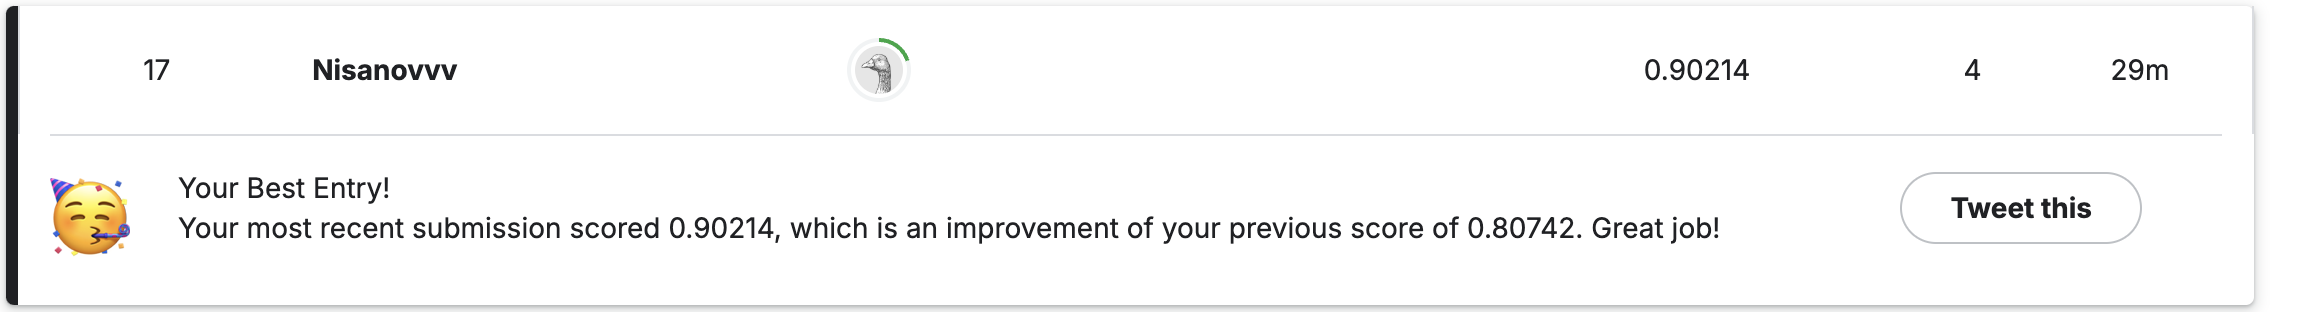